### BTC Strategy on Time series momentum - Tobias J. Moskowitz, Yao Hua Ooi, Lasse Heje Pedersen



In [19]:
import subprocess
import sys
import os
from datetime import datetime, timedelta, timezone
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import ccxt

pd.options.display.float_format = "{:.6f}".format



In [20]:
def fetch_btc_trades(lookback_hours: int = 24, limit_per_batch: int = 1000) -> pd.DataFrame:
    exchange = ccxt.binance({"enableRateLimit": True})
    symbol = "BTC/USDT"
    end = datetime.now(tz=timezone.utc)
    start = end - timedelta(hours=lookback_hours)
    
    all_trades = []
    since_id = None
    since_ms = int(start.timestamp() * 1000)
    max_ms = int(end.timestamp() * 1000)
    
    print(f"Fetching tick data from Binance...")
    while True:
        try:
            trades = exchange.fetch_trades(symbol, since=since_ms, limit=limit_per_batch, params={"untilId": since_id} if since_id else {})
            if not trades:
                break
            
            for trade in trades:
                ts = trade.get("timestamp")
                if ts and ts <= max_ms:
                    all_trades.append({
                        "timestamp": datetime.fromtimestamp(ts / 1000, tz=timezone.utc),
                        "price": float(trade.get("price", 0)),
                        "amount": float(trade.get("amount", 0)),
                        "side": trade.get("side", "unknown"),
                    })
                    if len(all_trades) >= 50000:
                        break
                if len(all_trades) >= 50000:
                    break
            
            if len(all_trades) >= 50000 or not trades:
                break
            
            since_id = trades[-1].get("id")
            since_ms = trades[-1].get("timestamp")
            
        except Exception as exc:
            print(f"Error fetching trades: {exc}")
            break
    
    df = pd.DataFrame(all_trades).sort_values("timestamp").reset_index(drop=True)
    print(f"Fetched {len(df)} trades")
    return df

In [21]:

def fetch_btc_ohlcv(timeframe: str = "1d", lookback_days: Optional[int] = None, max_days: int = 1000) -> pd.DataFrame:
    exchange = ccxt.binance({"enableRateLimit": True})
    symbol = "BTC/USDT"
    end = datetime.now(tz=timezone.utc)
    
    if lookback_days is not None:
        start = end - timedelta(days=lookback_days)
    else:
        start = datetime(2017, 7, 1, tzinfo=timezone.utc)
    
    since_ms = int(start.timestamp() * 1000)
    limit_per_request = 1000
    
    all_rows = []
    current_since = since_ms
    batch = 0
    
    while len(all_rows) < max_days:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=current_since, limit=limit_per_request)
            
            if not ohlcv or len(ohlcv) == 0:
                break
            
            for ts, op, high, low, close, vol in ohlcv:
                all_rows.append({
                    "timestamp": datetime.fromtimestamp(ts / 1000, tz=timezone.utc),
                    "open": float(op),
                    "high": float(high),
                    "low": float(low),
                    "close": float(close),
                    "volume": float(vol),
                })
            
            batch += 1
            if batch % 10 == 0:
                print(f"Fetched {len(all_rows)} bars so far...")
            
            if len(ohlcv) < limit_per_request:
                break
            
            current_since = ohlcv[-1][0] + 1
            
        except Exception as exc:
            print(f"Fetch error at timestamp {current_since}: {exc}")
            break
    
    df = pd.DataFrame(all_rows)
    df = df.drop_duplicates(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    
    print(f"Fetched {len(df)} bars from {df['timestamp'].min()} to {df['timestamp'].max()}")
    return df



In [22]:
df_btc = fetch_btc_ohlcv(timeframe="1d", lookback_days=None, max_days=5000)
df_btc.set_index("timestamp", inplace=True)
df_btc = df_btc[df_btc.index >= "2017-01-01"]
print(f"\nDonnees BTC recuperees: {len(df_btc)} jours")
print(f"Periode: {df_btc.index.min()} a {df_btc.index.max()}")
print(f"Prix actuel: ${df_btc['close'].iloc[-1]:,.2f}")
print(f"ATH: ${df_btc['close'].max():,.2f}")



Fetched 2995 bars from 2017-08-17 00:00:00+00:00 to 2025-10-28 00:00:00+00:00

Donnees BTC recuperees: 2995 jours
Periode: 2017-08-17 00:00:00+00:00 a 2025-10-28 00:00:00+00:00
Prix actuel: $112,695.19
ATH: $124,658.54


In [23]:
df_btc

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 00:00:00+00:00,4261.480000,4485.390000,4200.740000,4285.080000,795.150377
2017-08-18 00:00:00+00:00,4285.080000,4371.520000,3938.770000,4108.370000,1199.888264
2017-08-19 00:00:00+00:00,4108.370000,4184.690000,3850.000000,4139.980000,381.309763
2017-08-20 00:00:00+00:00,4120.980000,4211.080000,4032.620000,4086.290000,467.083022
2017-08-21 00:00:00+00:00,4069.130000,4119.620000,3911.790000,4016.000000,691.743060
...,...,...,...,...,...
2025-10-24 00:00:00+00:00,110078.190000,112104.980000,109700.010000,111004.890000,15005.169130
2025-10-25 00:00:00+00:00,111004.900000,111943.190000,110672.860000,111646.270000,6407.968640
2025-10-26 00:00:00+00:00,111646.270000,115466.800000,111260.450000,114559.400000,13454.477370


In [24]:
df_flows = pd.DataFrame()
df_flows['flows'] = df_btc['volume'].diff()
df_flows.dropna(inplace=True)
df_flows

,flows
timestamp,
2017-08-18 00:00:00+00:00,404.737887
2017-08-19 00:00:00+00:00,-818.578501
2017-08-20 00:00:00+00:00,85.773259
2017-08-21 00:00:00+00:00,224.660038
2017-08-22 00:00:00+00:00,274.941798
...,...
2025-10-24 00:00:00+00:00,-2567.923810
2025-10-25 00:00:00+00:00,-8597.200490
2025-10-26 00:00:00+00:00,7046.508730


In [37]:
fig_flows = go.Figure()
fig_flows.add_trace(go.Bar(x=df_flows.index,y=df_flows['flows'], marker_color=df_flows['flows'].apply(lambda x: 'green' if x >0 else 'red')))
fig_flows.update_layout(
    title="Flows Chart (variation du volume journalier)",
    xaxis_title="Date",
    yaxis_title="Flows (BTC)",
    template="plotly_white"
)
fig_flows.show()

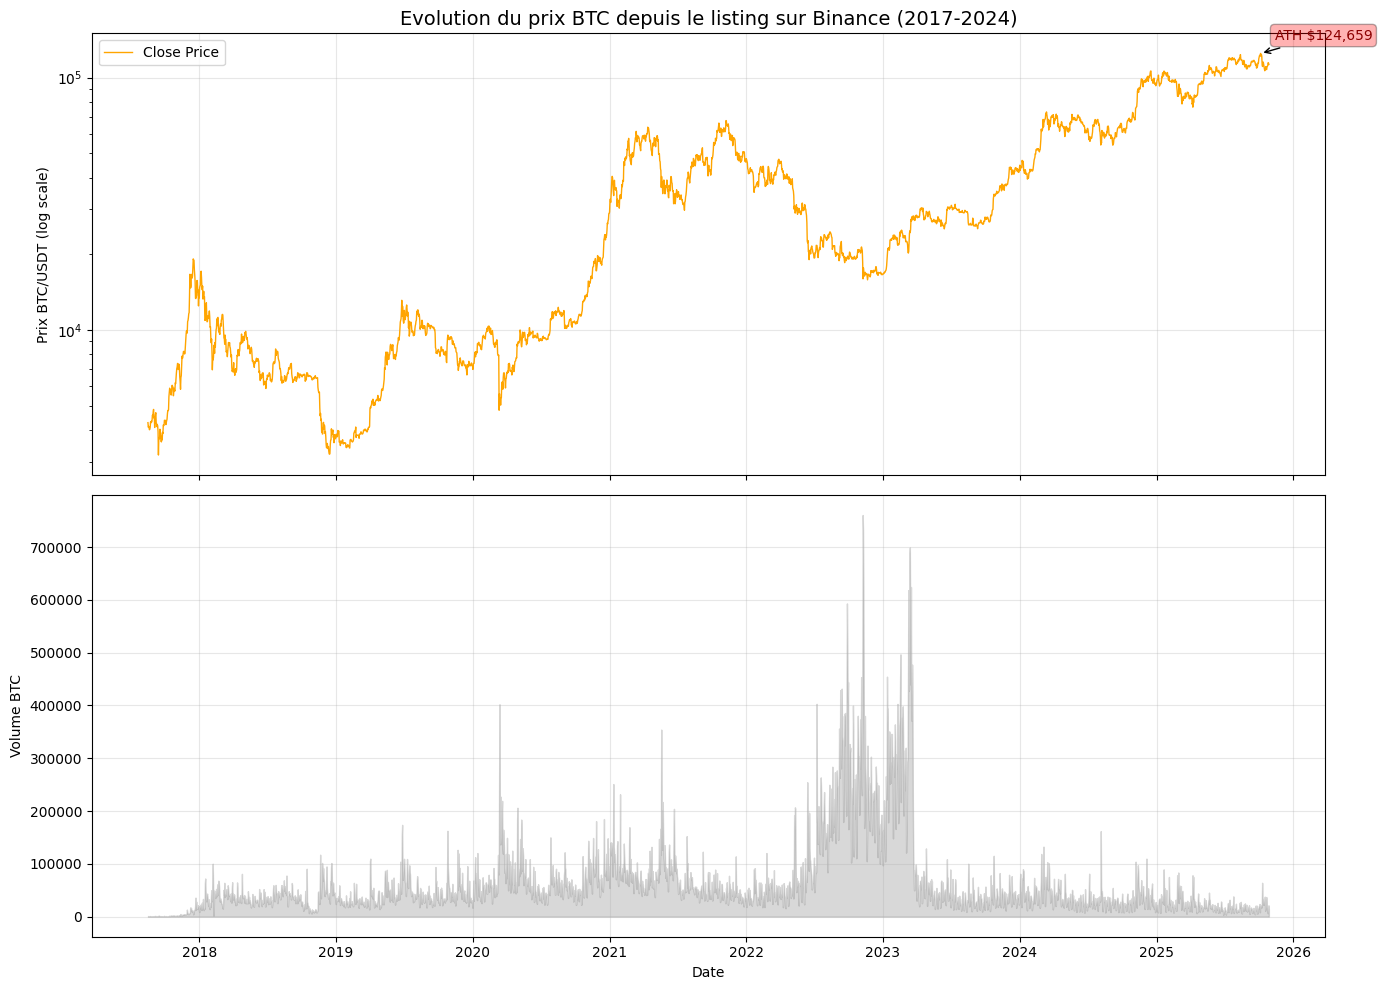

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(df_btc.index, df_btc['close'], linewidth=1, color='orange', label='Close Price')
ax1.set_yscale('log')
ax1.set_ylabel('Prix BTC/USDT (log scale)')
ax1.set_title('Evolution du prix BTC depuis le listing sur Binance (2017-2024)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

ath_date = df_btc['close'].idxmax()
ath_price = df_btc['close'].max()
ax1.annotate(f'ATH ${ath_price:,.0f}', 
             xy=(ath_date, ath_price), 
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
             fontsize=10, color='darkred')

ax2.fill_between(df_btc.index, df_btc['volume'], alpha=0.3, color='gray')
ax2.set_ylabel('Volume BTC')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Time-Series Momentum (TSM) de Pedersen



EWMA

\[
\sigma_t^2 = (1 - \lambda) r_{t-1}^2 + \lambda \sigma_{t-1}^2
\]

In [13]:
def compute_tsm_signals(
    prices: pd.Series,
    horizons: list[int] = [12, 24, 48],
    halflife: float = 0.5,
    vol_window: int = 24
) -> pd.DataFrame:
    close = prices.copy()
    returns = close.pct_change()
    vol = returns.rolling(vol_window).std()
    
    signals = pd.DataFrame(index=close.index)
    signals["close"] = close
    
    for h in horizons:
        ret_h = close / close.shift(h) - 1.0
        signals[f"return_h{h}"] = ret_h
        signal_norm = ret_h / (vol + 1e-9)
        signals[f"signal_h{h}"] = signal_norm
    
    combined = pd.Series(0.0, index=close.index)
    for i, h in enumerate(horizons):
        weight = halflife ** i
        combined += weight * signals[f"signal_h{h}"].fillna(0.0)
    
    signals["combined_signal"] = combined
    signals["volatility"] = vol
    signals["position"] = np.sign(combined).fillna(0).astype(int)
    
    return signals

signals_tsm = compute_tsm_signals(df_btc["close"])
print(f"Signaux calculés: {len(signals_tsm)}")
print(signals_tsm[["close", "combined_signal", "position"]].tail(20))


Signaux calculés: 2995
                                  close  combined_signal  position
timestamp                                                         
2025-10-09 00:00:00+00:00 121662.400000         8.644246         1
2025-10-10 00:00:00+00:00 112774.500000        -0.768378        -1
2025-10-11 00:00:00+00:00 110644.400000        -2.742342        -1
2025-10-12 00:00:00+00:00 114958.800000         0.405998         1
2025-10-13 00:00:00+00:00 115166.000000        -0.956409        -1
2025-10-14 00:00:00+00:00 113028.140000        -2.826609        -1
2025-10-15 00:00:00+00:00 110763.280000        -4.691435        -1
2025-10-16 00:00:00+00:00 108194.280000        -5.444345        -1
2025-10-17 00:00:00+00:00 106431.680000        -6.686194        -1
2025-10-18 00:00:00+00:00 107185.010000        -6.758886        -1
2025-10-19 00:00:00+00:00 108642.780000        -4.469571        -1
2025-10-20 00:00:00+00:00 110532.090000        -4.162245        -1
2025-10-21 00:00:00+00:00 108297.670000

In [14]:
def compute_metrics(prices: pd.Series, rsi_window: int = 14) -> pd.DataFrame:
    close = prices.dropna().copy()
    returns = close.pct_change().dropna()
    vol = returns.rolling(30).std() * np.sqrt(365)
    delta = close.diff()
    gain = delta.clip(lower=0.0)
    loss = -delta.clip(upper=0.0)
    roll_up = gain.ewm(alpha=1 / rsi_window, adjust=False).mean()
    roll_down = loss.ewm(alpha=1 / rsi_window, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-9)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    out = pd.DataFrame({
        "close": close,
        "return": returns,
        "vol_30d": vol,
        f"rsi_{rsi_window}": rsi,
    })
    return out

metrics = compute_metrics(df_btc["close"]) 
metrics.tail()


,close,return,vol_30d,rsi_14
timestamp,,,,
2025-10-24 00:00:00+00:00,111004.890000,0.008419,0.450671,47.018011
2025-10-25 00:00:00+00:00,111646.270000,0.005778,0.430046,48.376751
2025-10-26 00:00:00+00:00,114559.400000,0.026092,0.438588,54.130621
2025-10-27 00:00:00+00:00,114107.650000,-0.003943,0.438995,53.141450
2025-10-28 00:00:00+00:00,112732.940000,-0.012047,0.434444,50.138833


In [15]:
def backtest_ma(prices: pd.Series, fast: int = 50, slow: int = 200) -> pd.DataFrame:
    close = prices.dropna().copy()
    ma_fast = close.rolling(fast).mean()
    ma_slow = close.rolling(slow).mean()
    signal = (ma_fast > ma_slow).astype(int)
    ret = close.pct_change().fillna(0.0)
    strat_ret = signal.shift(1).fillna(0.0) * ret
    equity = (1.0 + strat_ret).cumprod()
    buy_hold = (1.0 + ret).cumprod()
    return pd.DataFrame({
        "equity": equity,
        "buy_hold": buy_hold,
        "signal": signal,
    })

bt = backtest_ma(df_btc["close"]).dropna()
bt.tail()


,equity,buy_hold,signal
timestamp,,,
2025-10-24 00:00:00+00:00,5.208637,25.904975,1
2025-10-25 00:00:00+00:00,5.238732,26.054652,1
2025-10-26 00:00:00+00:00,5.375424,26.734483,1
2025-10-27 00:00:00+00:00,5.354226,26.629059,1
2025-10-28 00:00:00+00:00,5.289721,26.308246,1


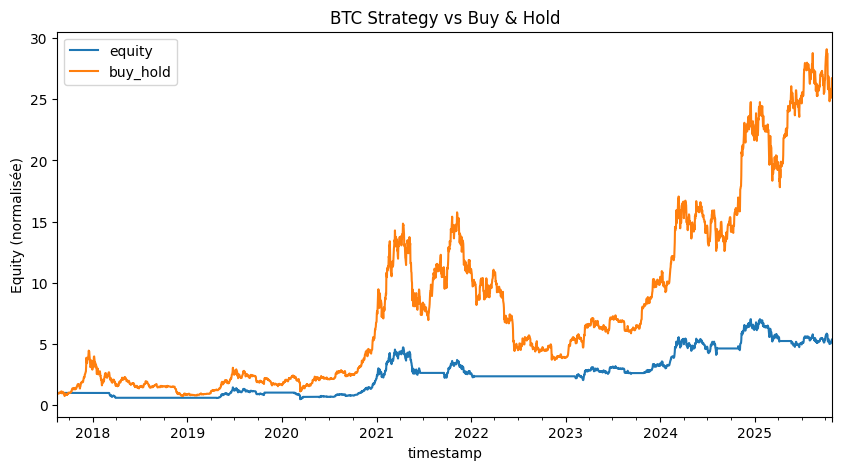

In [16]:
ax = bt[["equity","buy_hold"]].plot(figsize=(10,5), title="BTC Strategy vs Buy & Hold")
ax.set_ylabel("Equity (normalisée)")
plt.show()
